<div style="padding:20px; 
            color:#150d0a;
            margin:10px;
            font-size:220%;
            text-align:center;
            display:fill;
            border-radius:20px;
            border-width: 5px;
            border-style: solid;
            border-color: #ffaa30;
            background-color:#317900;
            color: white;
            overflow:hidden;
            font-weight:500"><strong>SriOryzaugur:</strong> Temporal Fusion Transformer</div>
            
<center>
<img src="https://www.researchgate.net/publication/355916352/figure/fig1/AS:1086496828334080@1636052438065/Temporal-Fusion-Transformer-architecture-4.ppm" width=700>
</center>

# **Table of contents**

1. [Install Packages 📥](#packages)
2. [Import Packages 📩](#import)
3. [Loading Dataset and Feature Engineering 🔬](#feature_engineering)
4. [Test Train Split 🪓](#split)
5. [Building and Training the Model 🏗️](#model)
6. [Testing 🧪](#test)

# **1. Install Packages 📥** <a class='anchor' id='packages'></a> [↑](#top)

In [1]:
!pip install torch pytorch-lightning pytorch_forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **2. Import Packages 📩** <a class='anchor' id='import'></a> [↑](#top)

In [2]:
# Import necessary packages
import copy
from pathlib import Path
import pickle
import warnings
import seaborn as sns
import matplotlib

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use("bmh")

import numpy as np
import pandas as pd

import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner

import torch
# Set device based on availability of CUDA GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

import warnings
warnings.filterwarnings('ignore')

# Set seed values for reproducibility
random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

In [3]:
DEVICE

'cuda'

# **3. Loading Dataset and Feature Engineering 🔬** <a class='anchor' id='feature_engineering'></a> [↑](#top)

In [4]:
# Define the path of the CSV file containing the dataset
df = pd.read_csv('/kaggle/input/sri-oryzaugur-dataset/imputed_processed_data.csv')
df['date'] = pd.to_datetime(df['date']) # Convert the date column to datetime format

# Filter the data to include only the rows before January 1st, 2020 and select relevant columns
df = df[df['date'] < '2020-01-01']
df = df[['date', 'price', 'anuradhapura_producer_price', 'kurunegala_producer_price', 'polonnaruwa_producer_price', 'exchange_rate', 'm1']]
df

,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
0,1996-01-01,18.07,7.75,7.900,8.180,53.685,73783
1,1996-02-01,18.70,8.17,8.260,8.760,53.685,77440
2,1996-03-01,18.49,7.95,7.850,7.990,53.685,81796
3,1996-04-01,18.52,8.25,8.010,8.290,54.735,79478
4,1996-05-01,19.02,8.38,8.500,8.340,54.950,76620
...,...,...,...,...,...,...,...
283,2019-08-01,89.06,43.58,43.600,46.185,179.200,818128
284,2019-09-01,92.08,45.50,46.654,49.630,182.000,843070
285,2019-10-01,96.74,49.98,49.708,51.310,181.050,810596
286,2019-11-01,99.21,52.11,51.250,51.480,180.850,817647


In [5]:
df = df.set_index('date')

# Standardize the values in each column
avgs = df.mean()
devs = df.std()

for col in df.columns:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]

df.reset_index(drop=False, inplace=True)

df

,date,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
0,1996-01-01,-1.327724,-1.233085,-1.238532,-1.202460,-1.780339,-1.100574
1,1996-02-01,-1.302855,-1.199386,-1.210139,-1.156829,-1.780339,-1.085641
2,1996-03-01,-1.311144,-1.217038,-1.242475,-1.217408,-1.780339,-1.067855
3,1996-04-01,-1.309960,-1.192967,-1.229856,-1.193806,-1.747144,-1.077320
4,1996-05-01,-1.290223,-1.182536,-1.191210,-1.189872,-1.740347,-1.088990
...,...,...,...,...,...,...,...
283,2019-08-01,1.474554,1.641783,1.577126,1.787546,2.187719,1.938706
284,2019-09-01,1.593766,1.795837,1.817994,2.058578,2.276239,2.040548
285,2019-10-01,1.777717,2.155296,2.058863,2.190750,2.246205,1.907951
286,2019-11-01,1.875218,2.326199,2.180481,2.204125,2.239883,1.936742


In [6]:
# list of column names to concatenate
series_to_merge = df.iloc[:, 1:].columns
num_of_series = len(series_to_merge)

In [7]:
# concatenate columns based on column names in cols_to_concat
combined_series = pd.concat([df[col] for col in series_to_merge], ignore_index=True)
combined_series.name = 'y'
combined_series = pd.DataFrame(combined_series)
combined_series

,y
0,-1.327724
1,-1.302855
2,-1.311144
3,-1.309960
4,-1.290223
...,...
1723,1.938706
1724,2.040548
1725,1.907951
1726,1.936742


In [8]:
combined_series['ds'] = pd.concat([df['date']] * num_of_series).reset_index(drop=True)
combined_series

,y,ds
0,-1.327724,1996-01-01
1,-1.302855,1996-02-01
2,-1.311144,1996-03-01
3,-1.309960,1996-04-01
4,-1.290223,1996-05-01
...,...,...
1723,1.938706,2019-08-01
1724,2.040548,2019-09-01
1725,1.907951,2019-10-01
1726,1.936742,2019-11-01


In [9]:
# Add a column to indicate the series to which each row belongs
series_arr = np.arange(num_of_series).reshape(-1, 1)
combined_series['series'] = np.repeat(series_arr, combined_series.shape[0]/num_of_series)
combined_series['series'] = combined_series['series'].astype(str)
combined_series

,y,ds,series
0,-1.327724,1996-01-01,0
1,-1.302855,1996-02-01,0
2,-1.311144,1996-03-01,0
3,-1.309960,1996-04-01,0
4,-1.290223,1996-05-01,0
...,...,...,...
1723,1.938706,2019-08-01,5
1724,2.040548,2019-09-01,5
1725,1.907951,2019-10-01,5
1726,1.936742,2019-11-01,5


In [10]:
# Add columns for the month and year
combined_series = (combined_series.merge((combined_series[['ds']].drop_duplicates(ignore_index=True).rename_axis('time_idx')).reset_index(), on = ['ds']))
combined_series['month'] = combined_series['ds'].dt.month
combined_series['year'] = combined_series['ds'].dt.year

# Adding a static variable for the Maha and Yala season
def classify_yaha_mala(row):
    month = row['month']
    
    if month >= 10 or month <= 4:
        return 'maha'
    else:
        return 'yala'
    
combined_series["season"] = combined_series.apply(classify_yaha_mala, axis=1)
combined_series

,y,ds,series,time_idx,month,year,season
0,-1.327724,1996-01-01,0,0,1,1996,maha
1,-1.233085,1996-01-01,1,0,1,1996,maha
2,-1.238532,1996-01-01,2,0,1,1996,maha
3,-1.202460,1996-01-01,3,0,1,1996,maha
4,-1.780339,1996-01-01,4,0,1,1996,maha
...,...,...,...,...,...,...,...
1723,2.523580,2019-12-01,1,287,12,2019,maha
1724,2.353995,2019-12-01,2,287,12,2019,maha
1725,2.444081,2019-12-01,3,287,12,2019,maha
1726,2.254109,2019-12-01,4,287,12,2019,maha


# **4. Test Train Split** 🪓 <a class='anchor' id='split'></a> [↑](#top)

In [11]:
# Define the training dataset
train = combined_series.copy()

max_prediction_length = 12
max_encoder_length = 60
training_cutoff = train["time_idx"].max() - max_prediction_length

print(max_encoder_length)
print(training_cutoff)

60
275


In [12]:
train.tail()

,y,ds,series,time_idx,month,year,season
1723,2.523580,2019-12-01,1,287,12,2019,maha
1724,2.353995,2019-12-01,2,287,12,2019,maha
1725,2.444081,2019-12-01,3,287,12,2019,maha
1726,2.254109,2019-12-01,4,287,12,2019,maha
1727,2.131998,2019-12-01,5,287,12,2019,maha


In [13]:
# Let's create the TS Dataset
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="y",
    group_ids=['series'], 
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['series', 'season'],
    time_varying_known_reals=['month', 'year'],
    time_varying_unknown_reals=['y'],
    categorical_encoders={'series': NaNLabelEncoder().fit(combined_series.series)},
    lags={'y': [3, 6, 12]},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True, 
)

# Create a validation dataset
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# Create dataloaders for the model
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [14]:
# This code performs hyperparameter optimization using Optuna library. 
# The function `optimize_hyperparameters` takes in training and validation data, and performs hyperparameter tuning.
# It saves the best model in `model_path` and returns a `study` object.

study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

# The `study` object is saved in a pickle file `test_study.pkl`.
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# The best hyperparameters are retrieved from the `study` object and printed.
hyperparams = study.best_trial.params
print(hyperparams)

[I 2023-05-04 14:44:32,171] A new study created in memory with name: no-name-f66608f1-06e8-4b34-b44f-83984f5b9584
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 14:48:27,721] Trial 0 finished with value: 0.16977538168430328 and parameters: {'gradient_clip_val': 0.04832356686677307, 'hidden_size': 55, 'dropout': 0.28598731358522267, 'hidden_continuous_size': 31, 'attention_head_size': 3, 'learning_rate': 0.020002978554020844}. Best is trial 0 with value: 0.16977538168430328.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 14:52:23,595] Trial 1 finished with value: 0.11341013759374619 and parameters: {'gradient_clip_val': 0.0845955193453239, 'hidden_size': 74, 'dropout': 0.20215780816556483, 'hidden_continuous_size': 37, 'attention_head_size': 4, 'learning_rate': 0.05125815967632988}. Best is trial 1 with value: 0.11341013759374619.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-05-04 14:56:14,041] Trial 2 finished with value: 0.19603590667247772 and

{'gradient_clip_val': 0.7991623487622617, 'hidden_size': 48, 'dropout': 0.18660348936741972, 'hidden_continuous_size': 35, 'attention_head_size': 4, 'learning_rate': 0.0016436000954437122}


In [15]:
pl.seed_everything(42)

# Initialize a PyTorch Lightning Trainer with specified options
trainer = pl.Trainer(
    accelerator=DEVICE,
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss()
)

INFO: Global seed set to 42


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: Learning rate set to 0.2884031503126607


suggested learning rate: 0.2884031503126607


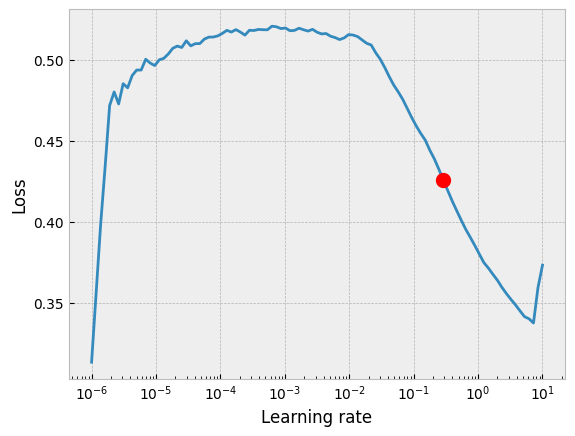

In [16]:
# Initialize a Tuner object and call its lr_find method to find the optimal learning rate.
# This method takes the trainer object, the target function (tft), and the training and validation data loaders.
# It also sets the maximum and minimum learning rates to try.
res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

# Get the suggested learning rate from the result object and print it.
learning_rate = res.suggestion()
print(f"suggested learning rate: {res.suggestion()}")

fig = res.plot(show=True, suggest=True)
fig.show()

# **5. Building and Training the Model 🏗️** <a class='anchor' id='model'></a> [↑](#top)

In [17]:
# Create a trainer object with specified parameters for training
trainer = pl.Trainer(
    max_epochs=200,     # Maximum number of epochs for training
    accelerator='gpu',  # Utilizing GPU acceleration
    devices=1,
    enable_model_summary=False,
    gradient_clip_val=hyperparams['gradient_clip_val'],
    callbacks=[],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=hyperparams['learning_rate'], 
    hidden_size=hyperparams['hidden_size'],
    attention_head_size=hyperparams['attention_head_size'],
    dropout=hyperparams['dropout'],
    hidden_continuous_size=hyperparams['hidden_continuous_size'],
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 209.4k


In [18]:
# The following code trains the `tft` model using the `train_dataloader` and validates it using the `val_dataloader`.
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# **6. Testing 🧪** <a class='anchor' id='testing'></a> [↑](#top)

In [19]:
# Get the path of the best performing model checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path

# Load the Temporal Fusion Transformer model from the best performing checkpoint
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Concatenate the actual values for all samples in the validation dataloader
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

# Generate forecasts using the trained model on the validation data
forecasts = tft.predict(val_dataloader, return_x=True, return_y=True, trainer_kwargs=dict(accelerator="cpu"))

# Generate raw forecasts using the trained model on the validation data
raw_forecasts = tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


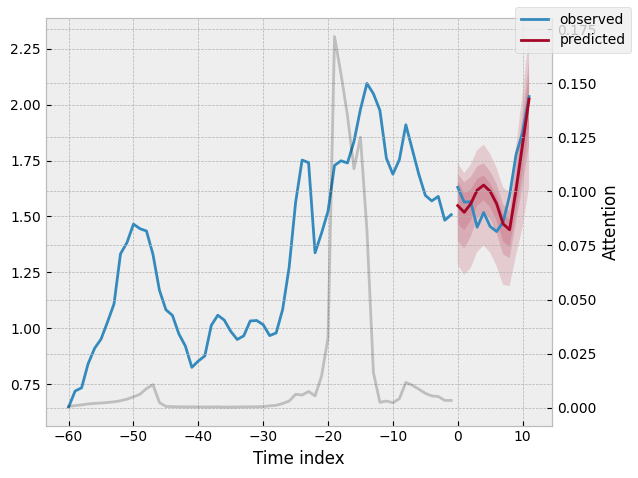

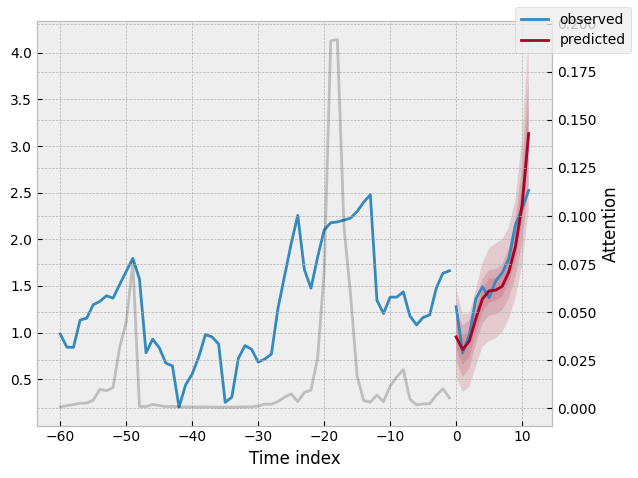

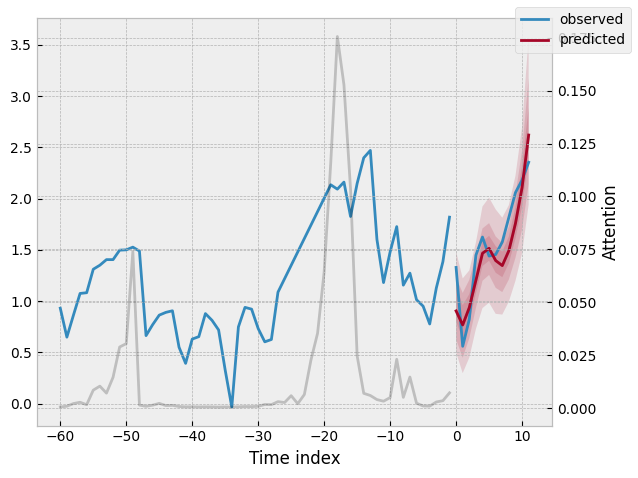

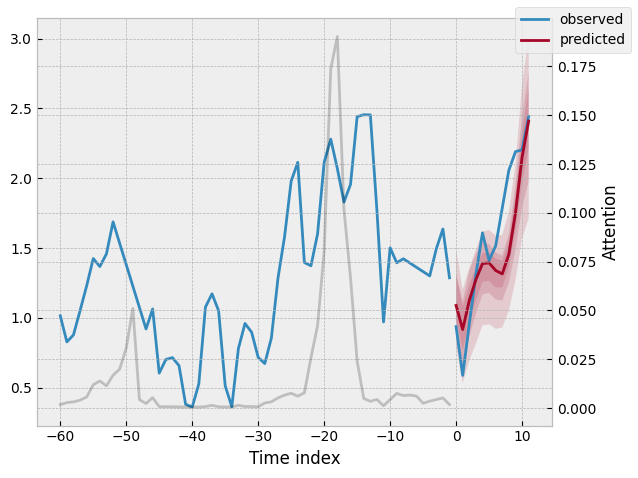

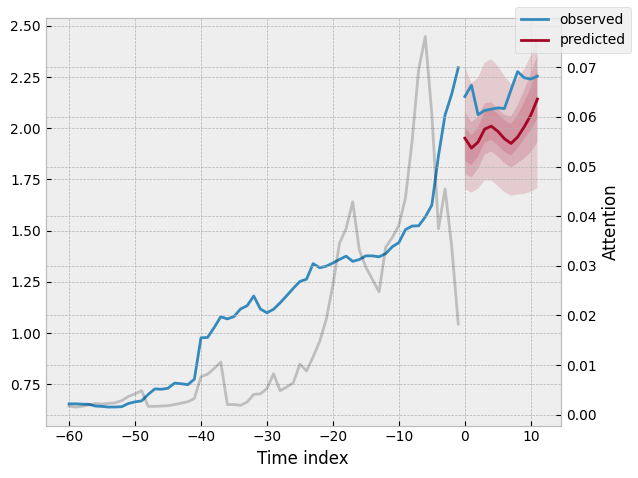

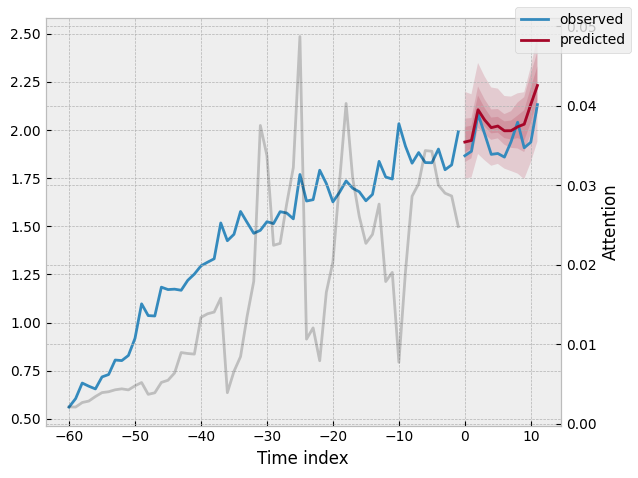

In [20]:
# Loop through unique values in combined_series.series column
for idx in range(combined_series.series.nunique()):
    
    # Plot the prediction for the idx-th series
    tft.plot_prediction(
        raw_forecasts.x,
        raw_forecasts.output,
        idx=idx,
    )

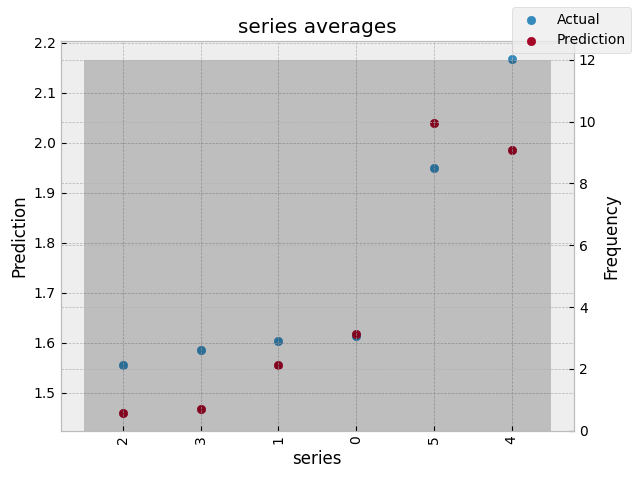

In [21]:
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(forecasts.x, forecasts.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals, name='series');

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x325 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x300 with 1 Axes>}

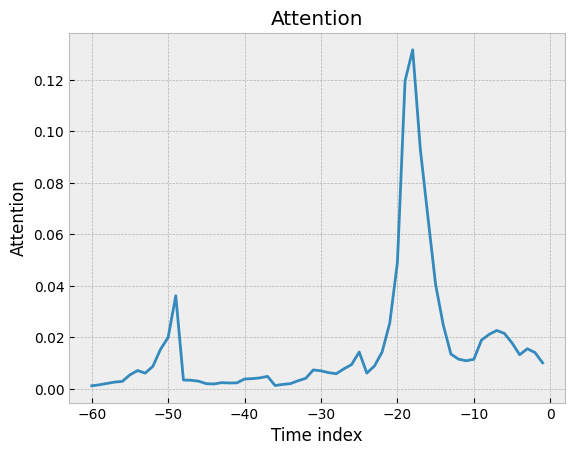

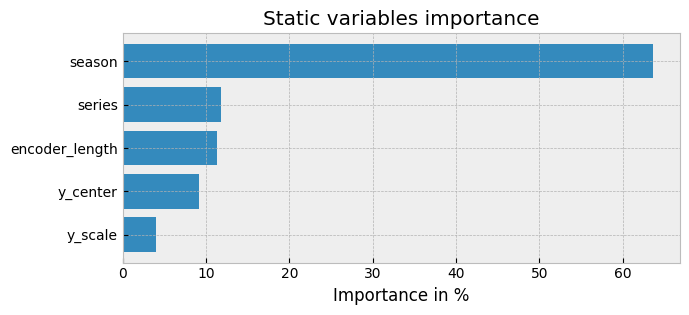

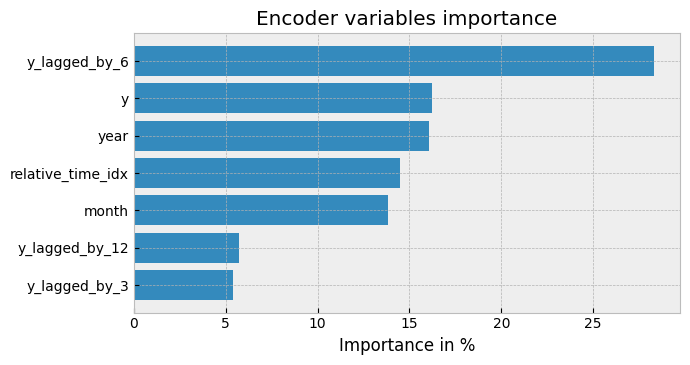

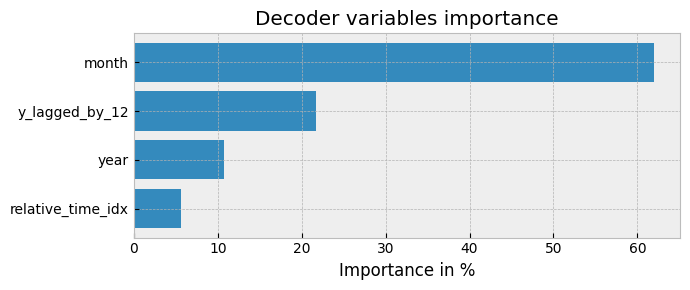

In [22]:
interpretation = best_tft.interpret_output(raw_forecasts.output, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [31]:
forecasts.output

tensor([[1.5483, 1.5184, 1.5561, 1.6174, 1.6400, 1.6122, 1.5565, 1.4664, 1.4402,
         1.6197, 1.8222, 2.0249],
        [0.9531, 0.8182, 0.9087, 1.1495, 1.3612, 1.4464, 1.4551, 1.4966, 1.6511,
         1.9237, 2.3653, 3.1326],
        [0.9050, 0.7684, 0.9377, 1.2026, 1.4666, 1.5151, 1.3960, 1.3472, 1.4925,
         1.7581, 2.1069, 2.6193],
        [1.0895, 0.9173, 1.1250, 1.2745, 1.3892, 1.3943, 1.3396, 1.3154, 1.4569,
         1.7520, 2.1506, 2.4102],
        [1.9511, 1.9032, 1.9324, 1.9955, 2.0099, 1.9850, 1.9487, 1.9257, 1.9571,
         2.0066, 2.0641, 2.1421],
        [1.9378, 1.9458, 2.1053, 2.0522, 2.0125, 2.0208, 1.9961, 1.9965, 2.0168,
         2.0304, 2.1337, 2.2314]])

In [32]:
mat

Prediction(output=tensor([[1.5483, 1.5184, 1.5561, 1.6174, 1.6400, 1.6122, 1.5565, 1.4664, 1.4402,
         1.6197, 1.8222, 2.0249],
        [0.9531, 0.8182, 0.9087, 1.1495, 1.3612, 1.4464, 1.4551, 1.4966, 1.6511,
         1.9237, 2.3653, 3.1326],
        [0.9050, 0.7684, 0.9377, 1.2026, 1.4666, 1.5151, 1.3960, 1.3472, 1.4925,
         1.7581, 2.1069, 2.6193],
        [1.0895, 0.9173, 1.1250, 1.2745, 1.3892, 1.3943, 1.3396, 1.3154, 1.4569,
         1.7520, 2.1506, 2.4102],
        [1.9511, 1.9032, 1.9324, 1.9955, 2.0099, 1.9850, 1.9487, 1.9257, 1.9571,
         2.0066, 2.0641, 2.1421],
        [1.9378, 1.9458, 2.1053, 2.0522, 2.0125, 2.0208, 1.9961, 1.9965, 2.0168,
         2.0304, 2.1337, 2.2314]]), x={'encoder_cat': tensor([[[0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 1],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],
         [0, 0],


In [35]:
devs

price                              25.332963
anuradhapura_producer_price        12.463182
kurunegala_producer_price          12.679100
polonnaruwa_producer_price         12.710677
exchange_rate                      31.631340
m1                             244908.400742
dtype: float64

In [34]:
avgs

price                              51.705174
anuradhapura_producer_price        23.118160
kurunegala_producer_price          23.603467
polonnaruwa_producer_price         23.464080
exchange_rate                     109.999514
m1                             343322.715278
dtype: float64

In [37]:
t.shape

torch.Size([6, 12])

In [84]:
# Assume that the input tensor is called 't'
t = forecasts.output

# Reverse the standardization by multiplying by the standard deviation and adding back the mean
# t_reversed = [[0*t.shape[1]]*t.shape[0]]
t_reversed = [[] for _ in range(t.shape[0])]

for i in range(t.shape[0]):
    t_reversed[i] = t[i] * devs[i] + avgs[i]
    t_reversed[i] = t_reversed[i].tolist()

# Print the resulting reversed tensor
print(t_reversed)

[[90.92717742919922, 90.17007446289062, 91.12623596191406, 92.67816162109375, 93.25140380859375, 92.54818725585938, 91.13656616210938, 88.8536148071289, 88.18871307373047, 92.7364501953125, 97.86773681640625, 103.00169372558594], [34.9974365234375, 33.31548309326172, 34.443885803222656, 37.445003509521484, 40.08256530761719, 41.145179748535156, 41.25322723388672, 41.77105712890625, 43.69627380371094, 47.09414291381836, 52.597450256347656, 62.16093444824219], [35.07762908935547, 33.34635543823242, 35.492530822753906, 38.851009368896484, 42.198307037353516, 42.8132209777832, 41.3032112121582, 40.68431854248047, 42.527061462402344, 45.89521408081055, 50.31749725341797, 56.81364440917969], [37.31254196166992, 35.123878479003906, 37.7640495300293, 39.66411590576172, 41.121368408203125, 41.18687438964844, 40.491485595703125, 40.183616638183594, 41.98168182373047, 45.733726501464844, 50.799461364746094, 54.09923553466797], [171.71653747558594, 170.2008056640625, 171.12255859375, 173.121337890

In [91]:
forecasted_df = pd.DataFrame(np.array(t_reversed).T, columns=df.columns[1:])
forecasted_df.insert(0, 'date', df['date'].iloc[-12:].reset_index(drop=True))
forecasted_df = forecasted_df.set_index('date')
forecasted_df.head(12)

,price,anuradhapura_producer_price,kurunegala_producer_price,polonnaruwa_producer_price,exchange_rate,m1
date,,,,,,
2019-01-01,90.927177,34.997437,35.077629,37.312542,171.716537,817899.6875
2019-02-01,90.170074,33.315483,33.346355,35.123878,170.200806,819875.5000
2019-03-01,91.126236,34.443886,35.492531,37.764050,171.122559,858937.5000
2019-04-01,92.678162,37.445004,38.851009,39.664116,173.121338,845930.0625
2019-05-01,93.251404,40.082565,42.198307,41.121368,173.574265,836190.3750
2019-06-01,92.548187,41.145180,42.813221,41.186874,172.786926,838236.1250
2019-07-01,91.136566,41.253227,41.303211,40.491486,171.640457,832188.6875
2019-08-01,88.853615,41.771057,40.684319,40.183617,170.912689,832274.7500
2019-09-01,88.188713,43.696274,42.527061,41.981682,171.903641,837245.4375


In [108]:
import plotly.express as px

# Create Line plot
original_df = pd.read_csv('/kaggle/input/sri-oryzaugur-dataset/imputed_processed_data.csv')

# Create a list of column names to loop through
cols_to_plot = forecasted_df.columns.tolist()

# Loop through each column and create a line plot
for col in cols_to_plot:
    # Create Line plot
    fig = px.line(original_df, x='date', y=col, template='presentation')
    fig.add_scatter(x=forecasted_df.index, y=forecasted_df[col], name=f'forecasted_{col}')

    # Add legend
    fig.update_layout(showlegend=True)

    # Display the plot
    fig.show()

In [117]:
from pytorch_forecasting.metrics import SMAPE, RMSE, MAPE, MAE

metrics = {
    'MAE': MAE()(forecasts.output, forecasts.y),
    'MAPE': MAPE()(forecasts.output, forecasts.y),
    'SMAPE': SMAPE()(forecasts.output, forecasts.y),
    'RMSE': RMSE()(forecasts.output, forecasts.y)
}

print(metrics)

{'MAE': tensor(0.1626), 'MAPE': tensor(0.1020), 'SMAPE': tensor(0.1034), 'RMSE': tensor(0.2072)}


In [109]:
forecasted_df.to_csv('forecasted_data.csv', index=False)